## Produce methylation enrichment barplots for CTCF and H3K9me3 figures

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


Bad key "text.kerning_factor" on line 4 in
/Users/annie/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import scipy as sp
from scipy import signal
from scipy.optimize import curve_fit
import scipy.stats
import itertools

In [123]:
data = pd.read_csv('ctcf_atac_v2.csv') # csv generated manually from ctcf_atac.sh results
data.head()

,target,A open no CTCF,mA open no CTCF,A open yes CTCF,mA open yes CTCF,A CTCF,mA CTCF,A no CTCF,mA no CTCF,mA/A open yes CTCF / mA/A open no CTCF,mA/A CTCF ChIP / mA/A no CTCF,mA/A open yes CTCF,mA/A open no CTCF,mA/A open no CTCF.1,mA/A open yes CTCF.1
0,CTCF,876480443,18784895,320943196,12097503,87264806,3149118,19324697813,43928158,1.758737,15.875212,0.037694,0.021432,0.021432,0.037694
1,IgG,131197184,75965,48198497,36137,13107714,7472,2924517598,694576,1.294880,2.400183,0.000750,0.000579,0.000579,0.000750
2,Hia5,123659137,2227363,45463776,1129148,12400043,281197,2745488772,9982204,1.378861,6.237072,0.024836,0.018012,0.018012,0.024836


In [124]:
#Give a uniform prior for methylation protportion. proportion p is distributed as Beta(1+mA, 1+(A-mA)) for each.
def calculate_ci(total_A_off_target, total_A_target, mA_off_target, mA_target):
    print((mA_target/total_A_target)/(mA_off_target/total_A_off_target))
    t = np.random.beta(1 + mA_target, 1 + (total_A_target - mA_target), size=100000)
    g = np.random.beta(1 + mA_off_target, 1 + (total_A_off_target - mA_off_target), size=100000)
    
    ratio = t/g
    
    ci_ratio_lower = np.percentile(ratio, 2.5)
    ci_ratio_upper = np.percentile(ratio, 97.5)
    
    return [ci_ratio_lower, ci_ratio_upper]

In [134]:
#Give a uniform prior for methylation protportion. proportion p is distributed as Beta(1+mA, 1+(A-mA)) for each.
# just for mA/A and not ratio
def calculate_ci_mA_A(totalA, mA):
    print(mA/totalA)
    r = np.random.beta(1 + mA, 1 + (totalA - mA), size=100000)
    
    ci_ratio_lower = np.percentile(r, 2.5)
    ci_ratio_upper = np.percentile(r, 97.5)
    
    return [ci_ratio_lower, ci_ratio_upper]

In [136]:
data['ci_noctcf'] = data.apply(lambda row : calculate_ci_mA_A(row['A open no CTCF'], row['mA open no CTCF']), axis=1)
data['ci_yesctcf'] = data.apply(lambda row : calculate_ci_mA_A(row['A open yes CTCF'], row['mA open yes CTCF']), axis=1)

0.02143218955998999
0.0005790139520067748
0.01801211826344866
0.03769359547351177
0.0007497536697046798
0.024836212460663188


In [125]:
cmap = ['#610345','#559CAD', '#A9E5BB']

In [138]:
data['ci_ratio_lower_noctcf'] = [item[0] for item in data['ci_noctcf']]
data['ci_ratio_upper_noctcf'] = [item[1] for item in data['ci_noctcf']]
data['ci_ratio_lower_yesctcf'] = [item[0] for item in data['ci_yesctcf']]
data['ci_ratio_upper_yesctcf'] = [item[1] for item in data['ci_yesctcf']]

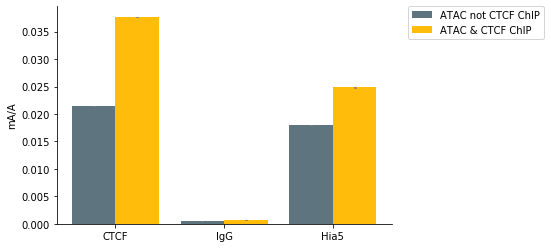

In [142]:
fig, ax1 = plt.subplots()
tidy = data.melt(id_vars='target').rename(columns=str.title)
tidy_small = tidy[(tidy['Variable'] == 'mA/A open no CTCF') |
    (tidy['Variable'] == 'mA/A open yes CTCF')]

error_opennoctcf = [data['mA/A open no CTCF'] - data['ci_ratio_lower_noctcf'], data['ci_ratio_upper_noctcf'] - data['mA/A open no CTCF']]
error_openyesctcf = [data['mA/A open yes CTCF'] - data['ci_ratio_lower_yesctcf'], data['ci_ratio_upper_yesctcf'] - data['mA/A open yes CTCF']]

barWidth = 0.4

bars1 = data['mA/A open no CTCF']
bars2 = data['mA/A open yes CTCF']

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, yerr=error_opennoctcf, color='#5E747F', ecolor='grey', capsize=1, label='ATAC not CTCF ChIP', width=barWidth);
plt.bar(r2, bars2, yerr=error_openyesctcf, color='#FFBC0A', ecolor='grey', capsize=1, label='ATAC & CTCF ChIP', width=barWidth);
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth/2 for r in range(len(bars1))], data['target'])
 
# Create legend & Show graphic
sns.despine(fig)
plt.ylabel('mA/A')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,)
plt.savefig(out + '/atac_ctcf_mA_A.pdf')

In [126]:
data['ci'] = data.apply(lambda row : calculate_ci(row['A open no CTCF'], row['A open yes CTCF'], 
                                     row['mA open no CTCF'], row['mA open yes CTCF']), axis=1)

1.758737499405048
1.2948801442627538
1.3788612809112195


In [127]:
data['ci_ratio_lower'] = [item[0] for item in data['ci']]
data['ci_ratio_upper'] = [item[1] for item in data['ci']]

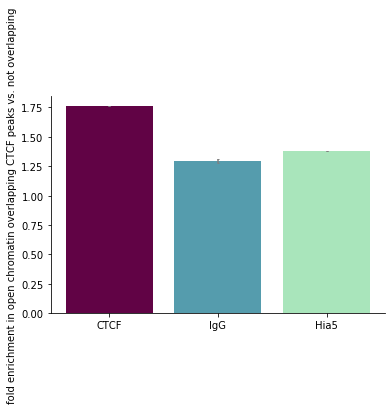

In [128]:
fig, ax1 = plt.subplots()
error = [data['mA/A open yes CTCF / mA/A open no CTCF'] - data['ci_ratio_lower'], data['ci_ratio_upper'] - data['mA/A open yes CTCF / mA/A open no CTCF']]
plt.bar(data['target'], data['mA/A open yes CTCF / mA/A open no CTCF'], data=data, yerr=error, color=cmap, ecolor='grey', capsize=1);
sns.despine(fig)
plt.ylabel('fold enrichment in open chromatin overlapping CTCF peaks vs. not overlapping');
plt.xlabel('')
plt.savefig('enrich_atac_ctcf.pdf')

In [129]:
data['ci'] = data.apply(lambda row : calculate_ci(row['A no CTCF'], row['A CTCF'], 
                                     row['mA no CTCF'], row['mA CTCF']), axis=1)

15.875211700203096
2.4001830947322387
6.237071500927893


In [130]:
data['ci_ratio_lower'] = [item[0] for item in data['ci']]
data['ci_ratio_upper'] = [item[1] for item in data['ci']]

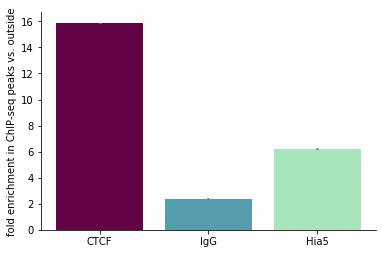

In [131]:
fig, ax1 = plt.subplots()
error = [data['mA/A CTCF ChIP / mA/A no CTCF'] - data['ci_ratio_lower'], data['ci_ratio_upper'] - data['mA/A CTCF ChIP / mA/A no CTCF']]
plt.bar(data['target'], data['mA/A CTCF ChIP / mA/A no CTCF'], data=data, yerr=error, color=cmap, ecolor='grey', capsize=1);
sns.despine(fig)
plt.ylabel('fold enrichment in ChIP-seq peaks vs. outside');
plt.xlabel('')
plt.savefig('enrich_ctcf.pdf')

In [549]:
data

,target,A open no CTCF,mA open no CTCF,A open yes CTCF,mA open yes CTCF,A CTCF,mA CTCF,A no CTCF,mA no CTCF,mA/A open yes CTCF / mA/A open no CTCF,...,mA/A open yes CTCF.1,ci,ci_ratio_lower,ci_ratio_upper,ci_noctcf,ci_yesctcf,ci_ratio_lower_noctcf,ci_ratio_upper_noctcf,ci_ratio_lower_yesctcf,ci_ratio_upper_yesctcf
0,CTCF,876480443,18784895,320943196,12097503,87264806,3149118,19324697813,43928158,1.758737,...,0.037694,"[15.857292264934735, 15.893068888625178]",15.857292,15.893069,"[0.02142260873971795, 0.021441812565343978]","[0.03767273224034646, 0.037714648330686586]",0.021423,0.021442,0.037673,0.037715
1,IgG,131197184,75965,48198497,36137,13107714,7472,2924517598,694576,1.294880,...,0.000750,"[2.346214989872014, 2.455319297126775]",2.346215,2.455319,"[0.0005749403865283445, 0.0005831517438500576]","[0.0007420298457553545, 0.0007575616568083405]",0.000575,0.000583,0.000742,0.000758
2,Hia5,123659137,2227363,45463776,1129148,12400043,281197,2745488772,9982204,1.378861,...,0.024836,"[6.214071127920335, 6.260163385867278]",6.214071,6.260163,"[0.017988650171142963, 0.01803542966585321]","[0.024791130795225495, 0.024881312736867885]",0.017989,0.018035,0.024791,0.024881


## H3K9me3 enrichment

In [113]:
data_k9me3 = pd.read_csv("h3k9me3_enrichment_v2.csv") # made manually from fig5ab_153.sh results

In [114]:
data_k9me3['ci'] = data_k9me3.apply(lambda row : calculate_ci(row['A not cut&run'], row['A cut&run'], 
                                     row['mA not cut&run'], row['mA cut&run']), axis=1)

3.580257724977363
1.0943454453711765
0.9385134114478316


In [115]:
data_k9me3.head()

,target,A cut&run,mA cut&run,A centromere,mA centromere,A not cut&run,mA not cut&run,A HOR,mA HOR,A not centromere,mA not centromere,mA/A cut&run / mA/A not cut&run,mA/A centromere / mA/A not centromere,mA/A HOR / mA/A not centromere,ci
0,H3K9me3,83049313,615274,312097637,1644982,1696202224,3509909,44947553,372989,2554227945,7049432,3.580258,1.909749,3.006737,"[3.5706136665058095, 3.5898850964284588]"
1,IgG,21871820,25360,82497381,93036,525395520,556668,9242198,7588,758096807,823092,1.094345,1.038693,0.756185,"[1.080573394784948, 1.1082726095001347]"
2,Hia5,56570643,272707,210819055,836441,1434710445,7369346,25131022,35971,2077732985,10597687,0.938513,0.777865,0.280622,"[0.9349139334980118, 0.9420898878238593]"


In [116]:
data_k9me3['ci_ratio_lower'] = [item[0] for item in data_k9me3['ci']]
data_k9me3['ci_ratio_upper'] = [item[1] for item in data_k9me3['ci']]

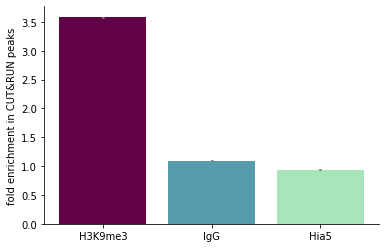

In [121]:
out = "/out"
fig, ax1 = plt.subplots()
error = [data_k9me3['mA/A cut&run / mA/A not cut&run'] - data_k9me3['ci_ratio_lower'], data_k9me3['ci_ratio_upper'] - data_k9me3['mA/A cut&run / mA/A not cut&run']]
plt.bar('target','mA/A cut&run / mA/A not cut&run', data=data_k9me3, yerr=error, color=cmap, ecolor='grey', capsize=1);
sns.despine(fig)
plt.ylabel('fold enrichment in CUT&RUN peaks');
plt.xlabel('')
plt.savefig(out + '/enrich_cutrun.pdf')

In [550]:
data_k9me3

,target,A cut&run,mA cut&run,A centromere,mA centromere,A not cut&run,mA not cut&run,A HOR,mA HOR,A not centromere,...,mA/A HOR / mA/A not centromere,ci,ci_ratio_lower,ci_ratio_upper,ci_cen,ci_hor,ci_ratio_lower_cen,ci_ratio_upper_cen,ci_ratio_lower_hor,ci_ratio_upper_hor
0,H3K9me3,83049313,615274,312097637,1644982,1696202224,3509909,44947553,372989,2554227945,...,3.006737,"[3.5706136665058095, 3.5898850964284588]",3.570614,3.589885,"[1.9065237762344756, 1.9129652350629043]","[2.996898554801723, 3.016601003158171]",1.906524,1.912965,2.996899,3.016601
1,IgG,21871820,25360,82497381,93036,525395520,556668,9242198,7588,758096807,...,0.756185,"[1.080573394784948, 1.1082726095001347]",1.080573,1.108273,"[1.031676967731421, 1.0457829391023041]","[0.7393682760624424, 0.7734113072611392]",1.031677,1.045783,0.739368,0.773411
2,Hia5,56570643,272707,210819055,836441,1434710445,7369346,25131022,35971,2077732985,...,0.280622,"[0.9349139334980118, 0.9420898878238593]",0.934914,0.942090,"[0.7761330840904077, 0.7795966760479361]","[0.2777194154007734, 0.2835658728627737]",0.776133,0.779597,0.277719,0.283566


In [118]:
data_k9me3['ci_cen'] = data_k9me3.apply(lambda row : calculate_ci(row['A not centromere'], row['A centromere'], 
                                     row['mA not centromere'], row['mA centromere']), axis=1)

1.9097485812762924
1.0386928818353989
0.7778647587549746


In [119]:
data_k9me3['ci_hor'] = data_k9me3.apply(lambda row : calculate_ci(row['A not centromere'], row['A HOR'], 
                                     row['mA not centromere'], row['mA HOR']), axis=1)

3.0067373832033435
0.7561854917431138
0.2806215421628996


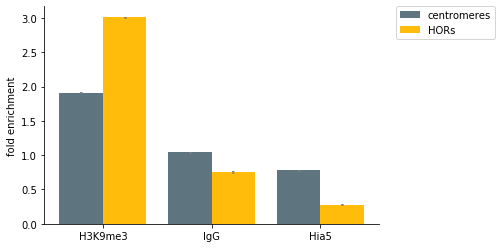

In [122]:
data_k9me3['ci_ratio_lower_cen'] = [item[0] for item in data_k9me3['ci_cen']]
data_k9me3['ci_ratio_upper_cen'] = [item[1] for item in data_k9me3['ci_cen']]
data_k9me3['ci_ratio_lower_hor'] = [item[0] for item in data_k9me3['ci_hor']]
data_k9me3['ci_ratio_upper_hor'] = [item[1] for item in data_k9me3['ci_hor']]
cmap2 = ['#5E747F', '#FFBC0A']
fig, ax1 = plt.subplots()
tidy = data_k9me3.melt(id_vars='target').rename(columns=str.title)
tidy_small = tidy[(tidy['Variable'] == 'mA/A HOR / mA/A not centromere') |
    (tidy['Variable'] == 'mA/A centromere / mA/A not centromere')]

error_cen = [data_k9me3['mA/A centromere / mA/A not centromere'] - data_k9me3['ci_ratio_lower_cen'], data_k9me3['ci_ratio_upper_cen'] - data_k9me3['mA/A centromere / mA/A not centromere']]
error_hor = [data_k9me3['mA/A HOR / mA/A not centromere'] - data_k9me3['ci_ratio_lower_hor'], data_k9me3['ci_ratio_upper_hor'] - data_k9me3['mA/A HOR / mA/A not centromere']]

barWidth = 0.4

bars1 = data_k9me3['mA/A centromere / mA/A not centromere']
bars2 = data_k9me3['mA/A HOR / mA/A not centromere']

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, yerr=error_cen, color='#5E747F', ecolor='grey', capsize=1, label='centromeres', width=barWidth);
plt.bar(r2, bars2, yerr=error_hor, color='#FFBC0A', ecolor='grey', capsize=1, label='HORs', width=barWidth);
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth/2 for r in range(len(bars1))], data_k9me3['target'])
 
# Create legend & Show graphic
sns.despine(fig)
plt.ylabel('fold enrichment')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(out + '/enrich_cen.pdf')